# 1. Setup the project

## First Install Dependencies

opencv provide image processing capabilities

In [5]:
!pip install tensorflow opencv-python matplotlib

## Import Dependencies

```cv2:``` opencv   plt.imshow() allow use to visualize an image(display image), check description by plt.imshow??

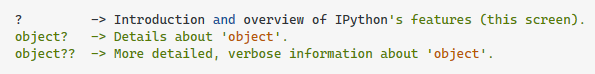

In [3]:
# Import standard dependencies
import cv2 #openCV
import os
import random
import numpy as np
from matplotlib import pyplot as plt

functional api is more flexible(powerful,sharing layrer nad branching) than sequential api which allows you to build more sophisticated neural network  
**Keras**(deep learning API running on top of Tensorflow

In [4]:
# Import tensorflow dependencies(functional api)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten #import bunch of layer type
import tensorflow as tf

`Model(input=[inputimage, verificationimage], output=[1,0])`, this define what we want the model's input be and outputs to be.  
`class L1Dist(Layer)`, inheritance from Layer so we can  create custom neural network layer  
conv2d for convolution network  
dense for fully connected layer  
MaxPooling2d for pull our layers together and effectively shrink the information(average, max) reduce data we actually passing to the next layer  
`input` define what we pass into the model use Input(shape=) to define the shape  
Flatten: takes all information we got from previous layer and **flattens it down into a single dimension** so we can pass convolutional neural network data to a dense layer

### Siamese neural network: 
one shot classification
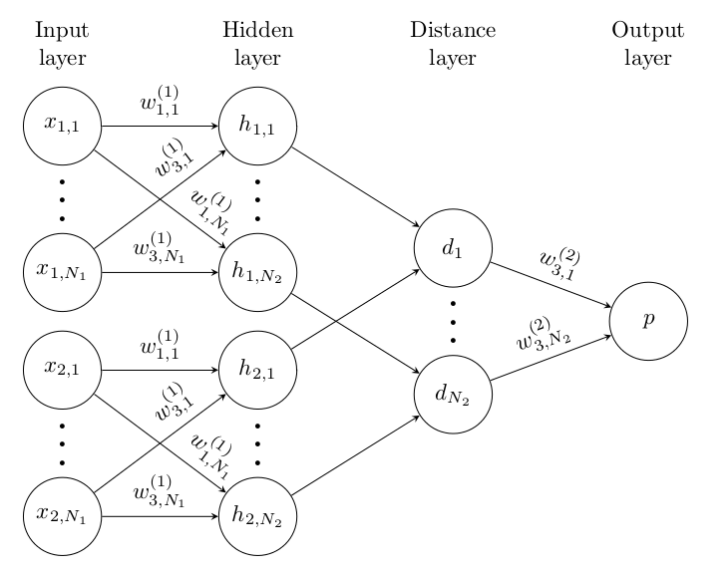
we have two input, x1, x2. 
we are passing through two images at the top at the same time and then we're going to have this distance layer(measures the similarity between the two images)
we're going to train our neural network to determine what that similarity is like so if it is very similar then we're going to output a 1

## Set GPU Growth(limitation)

In [8]:
# Avoid out of memory errors by setting GPU Memory Consumption Growth(otherwise expand to all over)
gpus = tf.config.experimental.list_physical_devices('GPU')#access all different on machine
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    #if true runtime initialization will not allocate all memory on the device

In [5]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Create Folder Structures

In [6]:
# Setup paths, join(data,positive) = data/positive, can join multiple items
POS_PATH = os.path.join('data', 'positive')# for varification image
NEG_PATH = os.path.join('data', 'negative')# for varification image,neural network should find those image be different
ANC_PATH = os.path.join('data', 'anchor') # for the input image

In [9]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# Collect Positive and Anchor images
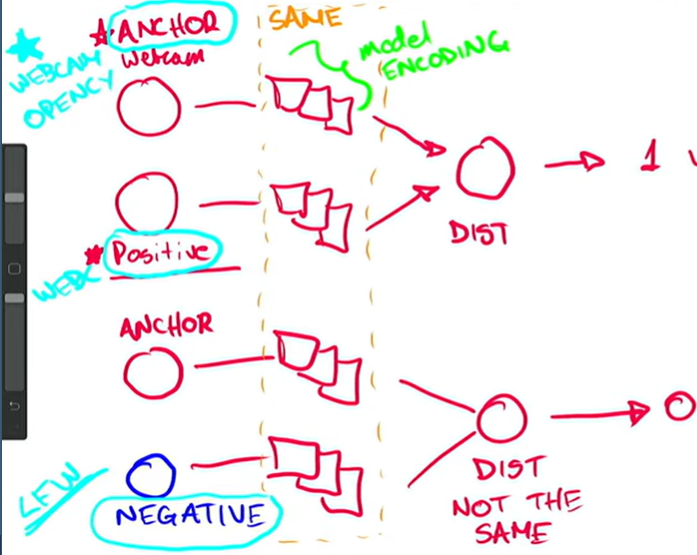

## Uncompress Labelled Faces in the Wild Dataset to negative folder

In [10]:
# http://vis-www.cs.umass.edu/lfw/

In [11]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset,data go to lfw folder
!tar -xf lfw.tgz

In [12]:
# Move images in lfw folder to the following repository folder data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file) #original path
        NEW_PATH = os.path.join(NEG_PATH, file) #new path(new directory + file name)
        os.replace(EX_PATH, NEW_PATH)#move the file

## Collect Positive and Anchor Classes
When we collect the image from webcam, we want our image to have **same dimension(250*250)** to the dataset in negative folder, so that the data processing will become lot more easier  

if get this, means the webcam not choosing correctly, the webcame/image device is empty

In [13]:
# Import uuid library to generate unique image names(id)
import uuid

In [14]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())) # format will insert the uuid to where {}

In [ ]:
# Establish a connection to the webcam
# opencv has a differnet channel order so coloring in output image may be weird
cap = cv2.VideoCapture(0) # pass video capture device number

while cap.isOpened(): #loop every single frame of webcam
    ret, frame = cap.read() #read the frame(one frame), ret is bool for whether correctly read, frame is actual image(height,width, channel number)
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]#change to 250*250, start from 120 for y and 200 for x
    
    # Collect anchor images
    #ord change to ASCII
    if cv2.waitKey(1) & 0XFF == ord('a'): #waitkey, wait the key press, delay 1ms to switch to next image
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))#append unique id to jpg, then tha path
        # Write out anchor image
        cv2.imwrite(imgname, frame)#write image to that path
    
    # Collect positive images
    if cv2.waitKey(1) & 0XFF == ord('p'): #mask the key get from waitkey by oxff(get last 8 bit), check whether that is == ASCII of p
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image, write image to that path
        cv2.imwrite(imgname, frame)
    
    #  display an image in a window
    cv2.imshow('Image Collection', frame)#window name, image
    
    # Breaking gracefully(stop collecting image)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show window
cv2.destroyAllWindows()

plt.imshow(frame[:250,:250, :])

# 2.x NEW - Data Augmentation

In [15]:
#for each image, we augment the image by different aspect to provide more samples to our modal training
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [16]:
import os
import uuid

In [ ]:
img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# Load and Preprocess Images

## Get Image Directories

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)# we only take 3000 images
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)#list_files create a set for all the files match to that pattern
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [18]:
dir_test = anchor.as_numpy_iterator()

In [19]:
print(dir_test.next())

b'data\\anchor\\e105b21a-c27c-11ed-bee4-c403a8279614.jpg'


## Preprocessing - Scale and Resize images

In [8]:
def preprocess(file_path): #like this file path data\\anchor\\5d3a7c8e-bf4b-11ed-a755-c403a8279614.jpg
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image(decode jpg file)，to array of pixel by pixel(R,G,B) this is called TENSOR
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image(from 0-255 color) to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [21]:
img = preprocess('data\\anchor\\1a7a8032-bfe3-11ed-b1e4-c403a8279614.jpg')

In [22]:
print(img)

tf.Tensor(
[[[0.7294118  0.7137255  0.70980394]
  [0.73333335 0.7176471  0.7137255 ]
  [0.73333335 0.7176471  0.7137255 ]
  ...
  [0.6894608  0.6737745  0.6698529 ]
  [0.6862745  0.67058825 0.6666667 ]
  [0.6852941  0.6696078  0.66568625]]

 [[0.73333335 0.7176471  0.7137255 ]
  [0.7294118  0.7137255  0.70980394]
  [0.7323529  0.71666664 0.7127451 ]
  ...
  [0.6845588  0.66887254 0.66495097]
  [0.6855392  0.6698529  0.66593134]
  [0.68235296 0.6666667  0.6627451 ]]

 [[0.73357844 0.71789217 0.7139706 ]
  [0.73333335 0.7176471  0.7137255 ]
  [0.73112744 0.71544117 0.7115196 ]
  ...
  [0.6884804  0.6727941  0.66887254]
  [0.6840686  0.66838235 0.6644608 ]
  [0.68235296 0.6666667  0.6627451 ]]

 ...

 [[0.64093137 0.7468137  0.7026961 ]
  [0.6188725  0.73406863 0.68602943]
  [0.6098039  0.7294118  0.6813725 ]
  ...
  [0.65318626 0.6492647  0.64142156]
  [0.6480392  0.64411765 0.6362745 ]
  [0.6480392  0.64411765 0.6362745 ]]

 [[0.66862744 0.80784315 0.7529412 ]
  [0.61715686 0.7563726  0

```dataset.map(preprocess)``` so we can apply preprocess to each file in the set/dataset

## Create Labelled Dataset

In [23]:
# (anchor, positive) => 1,1,1,1,1    tf.ones gives an array of ones
# (anchor, negative) => 0,0,0,0,0    tf.zeros gives an array of zeros

In [9]:
#zip:will zip three together so we can iterate them at the same time
#zip will combine each item one by one, (anchor,positive,1) or (anchor,negative 0)
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives) #combine into one big data set

In [25]:
samples = data.as_numpy_iterator()

In [26]:
exampple = samples.next()

In [27]:
exampple

(b'data\\anchor\\cd33263d-c27c-11ed-a365-c403a8279614.jpg',
 b'data\\positive\\7412237c-c27c-11ed-8ccc-c403a8279614.jpg',
 1.0)

## Build Training and Testing Partition of Data

In [10]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label) # prepocess both image

In [29]:
res = preprocess_twin(*exampple) # expand example to each fit each function input

In [ ]:
plt.imshow(res[1])

In [ ]:
res[2]

In [11]:
# Build dataloader pipeline
data = data.map(preprocess_twin) # apply the preprocess to our dataset
data = data.cache() #cache our images,first time will iterate and cache them, further iteration will use cache
data = data.shuffle(buffer_size=10000) # mix up images (not negative befind positive, mixed them up)

In [12]:
# Training partition
train_data = data.take(round(len(data)*.7)) # we take 70% of images (560 images)
train_data = train_data.batch(16)# turn this into array of group of 16 data
train_data = train_data.prefetch(8)#start prefetch/preprocessing next 8 images so no bottleneck on network
#now each data in train_data become [16images,16images,16 of 0 or 1]

In [13]:
train_data.as_numpy_iterator().next()

(array([[[[0.73333335, 0.7176471 , 0.7137255 ],
          [0.73333335, 0.7176471 , 0.7137255 ],
          [0.7323529 , 0.71666664, 0.7127451 ],
          ...,
          [0.6901961 , 0.6745098 , 0.67058825],
          [0.6862745 , 0.67058825, 0.6666667 ],
          [0.6901961 , 0.6745098 , 0.67058825]],
 
         [[0.7294118 , 0.7137255 , 0.70980394],
          [0.7323529 , 0.71666664, 0.7127451 ],
          [0.7323529 , 0.71666664, 0.7127451 ],
          ...,
          [0.6901961 , 0.6745098 , 0.67058825],
          [0.6870098 , 0.67132354, 0.66740197],
          [0.6901961 , 0.6745098 , 0.67058825]],
 
         [[0.7362745 , 0.7205882 , 0.71666664],
          [0.7355392 , 0.7198529 , 0.71593136],
          [0.73333335, 0.7176471 , 0.7137255 ],
          ...,
          [0.6862745 , 0.67058825, 0.6666667 ],
          [0.6840686 , 0.66838235, 0.6644608 ],
          [0.6901961 , 0.6745098 , 0.67058825]],
 
         ...,
 
         [[0.60539216, 0.7387255 , 0.6730392 ],
          [0.62696

In [14]:
# Testing partition
test_data = data.skip(round(len(data)*.7)) 
test_data = test_data.take(round(len(data)*.3)) # take the next 30% data for the testing
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Create Neural Network Model
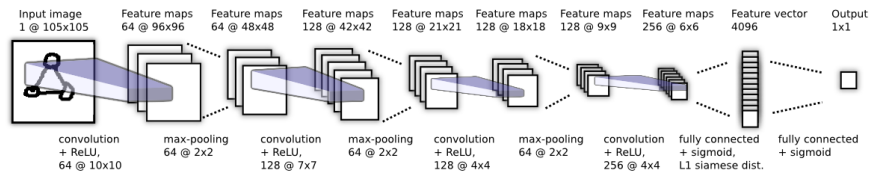
so the comfolution will take 64 filters, each filter(convolution kernel) is 10 * 10 for first convolution
maxpooling will take 64 units(generated by convolution) take the max of 2 by 2 box. padding = 1,box start from (-1.-1),add line and column of 0s around image.

In [ ]:
MaxPooling2D??

## Build Embedding Layer

In [ ]:
inp = Input(shape=(100,100,3), name='input_image')

In [ ]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [ ]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [ ]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [ ]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [ ]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [ ]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
mod.summary()

In [15]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')# set input be 100*100*3 image，with layer name called 'input_image'
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)# use 64 kernels each have dimension 10*10
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)# pooling size 64*64, pool move by 2
    #padding=same, add zeros to the outside of shape so output has the same height/width dimension as the input.
    # for pooling layrer, finally it will combine all img together(generate by each convolution kernel) so each cell has same weight to output
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4) # change 256*6*6 to 1*9216
    d1 = Dense(4096, activation='sigmoid')(f1) # fully connected layer, 9216 nodes,each connect to all 4096 nodes
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [16]:
embedding = make_embedding()

In [17]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

## Build Custom Distance Layer

In [18]:
# Siamese L1 Distance class
class L1Dist(Layer): # create out own layer, inherit from Layer class
    
    # Init method - inheritance，kwargs=key word arguments(dict)
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding) 
    #return a tensor(same number as input), each element is absolute value of corresponding element in input

## Make Siamese Model

In [ ]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [ ]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [ ]:
siamese_layer = L1Dist()

In [ ]:
distances = siamese_layer(inp_embedding, val_embedding)

In [ ]:
classifier = Dense(1, activation='sigmoid')(distances)

In [ ]:
classifier

In [ ]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_network.summary()

In [19]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    
    #First we pass two images through embedding model(show at beginning)
    #combine two model use a distance layer, output 4096(same as input) units
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    # pass 4096 unit into 1 unit for the output percentage
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [20]:
siamese_model = make_siamese_model()

In [21]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

# Training the Neural Network

## Setup Loss and Optimizer

In [22]:
binary_cross_loss = tf.losses.BinaryCrossentropy() #loss function use cross-entropy loss funciton

In [23]:
opt = tf.keras.optimizers.Adam(1e-4) # use adam algorithm with learning rate of 0.0001

## Establish Traning Checkpoints

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt') # system will save the checkpoint here(start with ckpt append some unique numbers)
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)
# Parameter of Checkpoint is **kwargs, save opt and siamese_model to the checkpoint
# Manages saving/restoring trackable values to disk.

## Build Train Step Function
we pass each batch of data and do the training at a time

In [ ]:
test_batch = train_data.as_numpy_iterator()

In [ ]:
batch_1 = test_batch.next()

In [ ]:
X = batch_1[:2]

In [ ]:
y = batch_1[2]

In [ ]:
y

In [ ]:
tf.losses.BinaryCrossentropy??

In [25]:
#tf.function can change the python styled code into Tensorflow calculation graph which has more efficiency
@tf.function
def train_step(batch): # batch will be the batch of data (16images,16images 16labels)
    
    # Record all of our operations in the neural network for automatic differentiation used later
    #operation within this context is being recorded, later we can use gradient() with two trainiable variable to 
    #  find gradient of two variable by using operation recorded
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2] # get the first two value(images)
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True) #put inputs into model, training=true so certain layer will activite
        # Calculate loss
        loss = binary_cross_loss(y, yhat) #true value(correct value), predicted value
    print(loss)
        
    # Calculate gradients
    grads = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    # apply those gradients to weight of each variable to optimizer(reduce loss)
    opt.apply_gradients(zip(grads, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## Build Training Loop
```EPOCHS``` is number of time we iterate all over through the data  
```iterations``` each iteration will loop a batch and update the weight

In [26]:
# Import metric calculations, used those metric to evaluate performance 
from tensorflow.keras.metrics import Precision, Recall
#recall produce true_positive / (true_positive + false_negative)
#Precision shows proportion of positive identification is actually correct
#Recall shows what proportion of actual positives were identified correctly

In [27]:
def train(data, EPOCHS): 
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data)) #progress bar, pass total number of data
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch) # apply training function just defined
            
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            
            
            # update progress bar, pass the index of current step
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints every 10 epoch
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix) #start with ckpt

## Train the model

In [28]:
EPOCHS = 20

In [29]:
train(train_data, EPOCHS)


 Epoch 1/20
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
263/263 [==============================] - 114s 403ms/step
0.0010232921 0.87677723 0.988776

 Epoch 2/20
263/263 [==============================] - 104s 394ms/step
0.0031348467 0.96055794 0.996507

 Epoch 3/20
263/263 [==============================] - 103s 391ms/step
0.0159126 0.9721823 0.99852216

 Epoch 4/20
263/263 [==============================] - 102s 388ms/step
0.06563761 0.985398 0.998568

 Epoch 5/20
263/263 [==============================] - 101s 386ms/step
0.0026043316 0.98345155 0.9990394

 Epoch 6/20
263/263 [==============================] - 101s 383ms/step
0.01601757 0.9980843 0.9985625

 Epoch 7/20
263/263 [==============================] - 100s 379ms/step
0.0001540319 0.9990521 1.0

 Epoch 8/20
263/263 [==============================] - 100s 379ms/step
2.0945306e-05 1.0 0.9995285

 Epoch 9/20
263/263 [==

# Evaluate Model

## Import Metrics

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## Make Predictions

In [31]:
# Get a batch of test data
#16 anchor images, 16 test images, 16values
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [32]:
#input image, validation image
y_hat = siamese_model.predict([test_input, test_val])

In [33]:
# Post processing the results 
#return 1 if prediction in y_hat > 0.5
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1]

In [34]:
y_true

array([0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.],
      dtype=float32)

## Calculate Metrics Values
```Recall```=True positive / (True positive + False negative)  
```Precision```=True positive / (True positive + False positive)

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat) # update state will accumulate those values(add those to what we updated before)

# Return Recall Result
m.result().numpy()

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

## Visualize Results

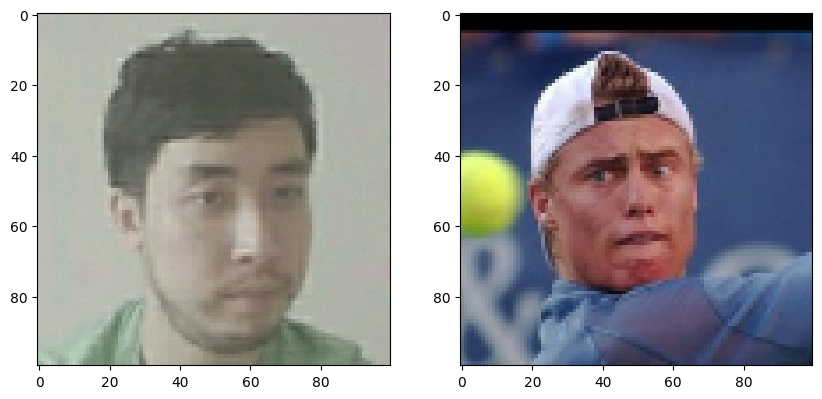

0.0


In [35]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1) # put to first of 1*2 plot
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders the plot images
plt.show()

print(y_true[1])

# Save the Trained Model

In [44]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [ ]:
L1Dist

In [28]:
# Reload model 
# we need to use custom_object to load our custom objects, because it only save structure and weights
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                    custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [39]:
# Make predictions with reloaded model
#on one batch
siamese_model.predict([test_input, test_val])

array([[1.0000000e+00],
       [7.5613321e-17],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9345475e-01],
       [4.9213974e-17],
       [1.0000000e+00],
       [9.9996030e-01],
       [7.9377585e-14],
       [2.4821988e-16],
       [6.5692270e-16],
       [1.0000000e+00],
       [6.4007630e-14],
       [1.2577254e-12],
       [9.9999952e-01]], dtype=float32)

In [ ]:
# View model summary
siamese_model.summary()

# Real Time Test
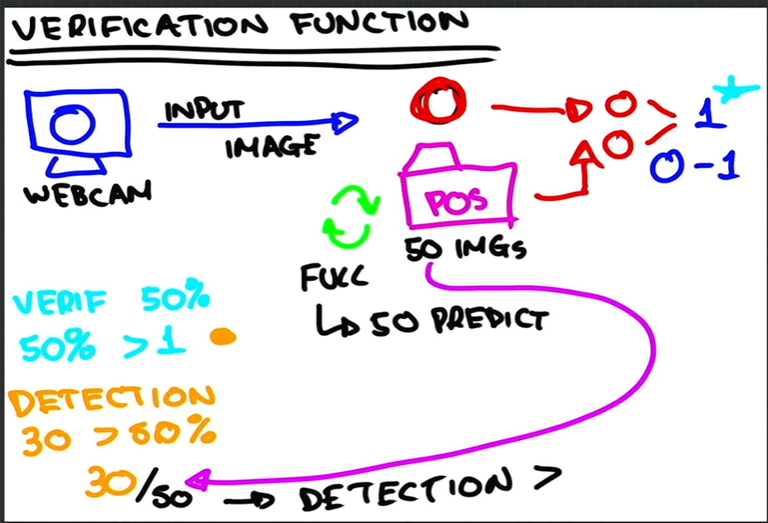

## Verification Function
we create a verification function to verify our data, we predict our input image to all images in verification_images
```detection```shows how many prediction is above the threshold(positive)  
```verification``` shows percentage verified to be positive

In [ ]:
application_data\verification_images

In [ ]:
os.listdir(os.path.join('application_data', 'verification_images'))

In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [5]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    # loop over all the images inside the verification_images folder
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [6]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

NameError: name 'siamese_model' is not defined

In [ ]:
np.sum(np.squeeze(results) > 0.9)

In [ ]:
results